In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

seed = np.random.seed(0)
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_rows', 1000)

In [2]:
train_data_apartments = pd.read_csv("data/apartments_train.csv")
train_data_buildings = pd.read_csv("data/buildings_train.csv")

train_data = pd.merge(train_data_apartments, train_data_buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
num_of_training_samples = train_data.shape[0]
# Don't drop outliers, as it worsens submit performance
y_train = (np.asarray(train_data.price))

test_data_apartments = pd.read_csv("data/apartments_test.csv")
test_data_buildings = pd.read_csv("data/buildings_test.csv")

test_data = pd.merge(test_data_apartments, test_data_buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
test_ids = test_data.id

train_data = train_data.drop("id", axis = 1)
test_data = test_data.drop("id", axis = 1)

metro_coordinates = pd.read_csv("data/metro.csv")

print("Amount of duplicates in training data: ", len(train_data[train_data.duplicated()]))


Amount of duplicates in training data:  465


Amount of ceilings higher than 200m:  31
Amount of ceilings between 25m and 200m:  8


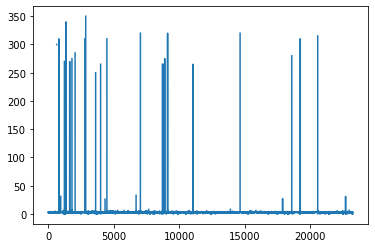

In [3]:
all_data = pd.concat([train_data, test_data])

plt.plot(all_data.ceiling)
print("Amount of ceilings higher than 200m: ", len(all_data.ceiling[all_data.ceiling >200]))
print("Amount of ceilings between 25m and 200m: ", len(all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)]))
# Rescaling out of scale ceilings
all_data.ceiling[all_data.ceiling > 200] = all_data.ceiling/100
all_data.ceiling[(all_data.ceiling > 25) & (all_data.ceiling < 200)] = all_data.ceiling/10

In [4]:
def haversine_array(lat1, lng1, lat2 = 55.75, lng2 = 37.6):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [5]:
def euclid_dist_from_center(lat, long):
    lat_city_center = 55.75
    long_city_center = 37.6

    return np.sqrt(np.power(np.abs(lat_city_center - lat), 2) + np.power(np.abs(long_city_center - long), 2))

In [6]:
# Unifying street and address
all_data["street_and_address"] = all_data.street + " " + all_data.address
# Adding shared and private bathrooms
all_data["bathrooms"] = all_data.bathrooms_shared  + all_data.bathrooms_private
# Adding balconies and loggias
all_data["balconies_and_loggias"] = all_data.balconies + all_data.loggias



#print(all_data[np.isnan(all_data.latitude)])

# Imputing coordinates outside of moscow and NaNs

#Бунинские Луга ЖК к2/2/1 = Ulitsa Aleksandry Monakhovoy, 97, coordinates: 55.5415152, 37.4821752
# улица 1-я Линия 57, coordinates: 55.6324711, 37.4536057
#улица Центральная 75 and 48, ESTIMATED coordinates: 55.750651,37.6083208
# пос. Коммунарка Москва А101 ЖК. coordinates: 55.5676692, 37.4816608
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/1"] = 37.4821752
all_data.latitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 55.5415152
all_data.longitude[all_data.street_and_address == "Бунинские Луга ЖК к2/2/2"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица 1-я Линия 57"] = 55.6324711
all_data.longitude[all_data.street_and_address == "улица 1-я Линия 57"] = 37.4536057
all_data.latitude[all_data.street_and_address == "улица Центральная 75"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 75"] = 37.4821752
all_data.latitude[all_data.street_and_address == "улица Центральная 48"] = 55.5415152
all_data.longitude[all_data.street_and_address == "улица Центральная 48"] = 37.4821752
# NaNs
all_data.latitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 55.5676692
all_data.longitude[all_data.street_and_address == "пос. Коммунарка Москва А101 ЖК"] = 37.4816608



# New feature: Euclidean distance from the city center
all_data["dist_from_city_center"] = haversine_array(all_data.latitude, all_data.longitude)
all_data = all_data.drop(["address", "street", "bathrooms_shared", "bathrooms_private", "balconies", "loggias",
"windows_court", "windows_street", "elevator_service", "elevator_passenger", "garbage_chute", 
"layout", "parking", "heating", "elevator_without", "new", "building_id"], axis = 1)



In [7]:
def euclid_dist_from_center(lat, long, lat2 = 55.75, long2 = 37.6):

    return np.sqrt(np.power(np.abs(lat2 - lat), 2) + np.power(np.abs(long2 - long), 2))

In [8]:
broadcasted_lat = np.broadcast_to(np.expand_dims(np.asarray(all_data.latitude), axis = 1), (33222,268))
broadcasted_long = np.broadcast_to(np.expand_dims(np.asarray(all_data.longitude), axis = 1), (33222,268))

broadcasted_metro_lat = np.broadcast_to(np.expand_dims(np.asarray(metro_coordinates.latitude), axis=1).T, (33222,268))
broadcasted_metro_long = np.broadcast_to(np.expand_dims(np.asarray(metro_coordinates.longitude), axis=1).T, (33222,268))

#print(np.sum((haversine_array(broadcasted_lat, broadcasted_long, broadcasted_metro_lat, broadcasted_metro_long) <= 5), axis = 1))

all_data["dist_to_nearest_metro"] = np.sum((haversine_array(broadcasted_lat, broadcasted_long, broadcasted_metro_lat, broadcasted_metro_long) <= 5), axis = 1)
print(all_data.dist_to_nearest_metro)

0        6
1       13
2       15
3       13
4        7
        ..
9932    19
9933    39
9934     3
9935    36
9936     0
Name: dist_to_nearest_metro, Length: 33222, dtype: int32


In [9]:
#print(all_data.latitude[np.isnan(all_data.district)].values)
#print((all_data.longitude[np.isnan(all_data.district)]).values)
#print(all_data.groupby("district").mean().longitude)
#print(all_data.groupby("district").mean().latitude)

all_data.district[(all_data.latitude==55.59516) & (all_data.longitude==37.741109)] = 5.0
all_data.district[(all_data.latitude==55.5676692) & (all_data.longitude==37.4816608)] = 11.0
all_data.district[(all_data.latitude==55.921627) & (all_data.longitude==37.781578)] = 3.0
all_data.district[(all_data.latitude==55.5415152) & (all_data.longitude==37.4821752)] = 11.0
all_data.district[(all_data.latitude==55.6324711) & (all_data.longitude==37.4536057)] = 6.0
all_data.district[(all_data.latitude==55.583551) & (all_data.longitude==37.711356)] = 5.0
all_data.district[(all_data.latitude==55.932127) & (all_data.longitude==37.793705)] = 3.0

In [10]:
print(all_data.keys())

Index(['seller', 'price', 'area_total', 'area_kitchen', 'area_living', 'floor',
       'rooms', 'ceiling', 'condition', 'phones', 'latitude', 'longitude',
       'district', 'constructed', 'material', 'stories', 'street_and_address',
       'bathrooms', 'balconies_and_loggias', 'dist_from_city_center',
       'dist_to_nearest_metro'],
      dtype='object')


<AxesSubplot:>

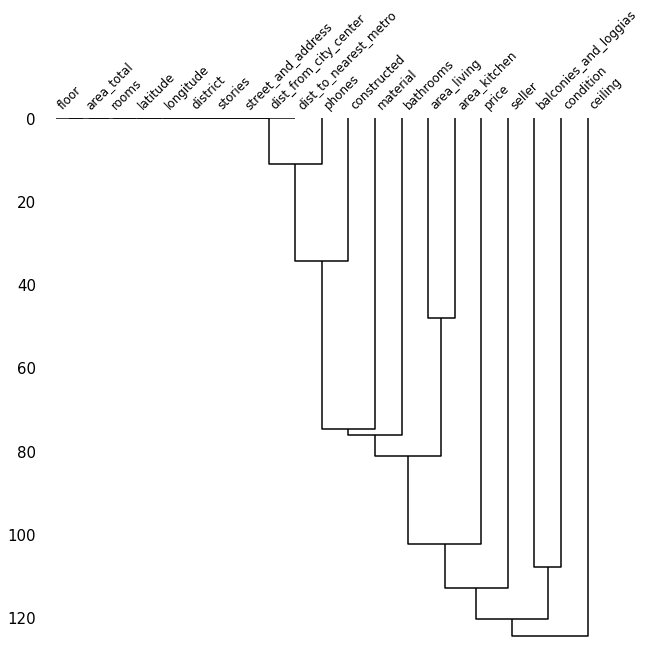

In [11]:
import missingno as msno
msno.dendrogram(all_data, inline=True, fontsize=12, figsize=(10, 10))

100
6954
2348


(array([1684.,    0., 1544.,    0., 1548.,    0.,  748.,    0.,  260.,
         117.]),
 array([1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ]),
 <BarContainer object of 10 artists>)

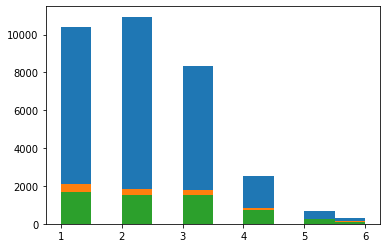

In [12]:
print(len(all_data[(all_data.area_living) == 0]))
print(len(all_data[np.isnan(all_data.area_kitchen)]))
print(len(np.unique(all_data.street_and_address[np.isnan(all_data.area_kitchen)])))
plt.hist(all_data.rooms)
plt.hist(all_data.rooms[np.isnan(all_data.area_kitchen)])
plt.hist(all_data.rooms[np.isnan(all_data.area_living)])

100


(array([22.,  0., 33.,  0.,  0., 25.,  0., 18.,  0.,  2.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

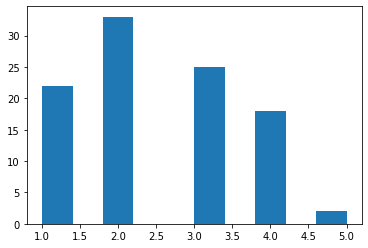

In [13]:
print(len(all_data.rooms[all_data.area_living == 0]))
plt.hist(all_data.rooms[all_data.area_living == 0])

18.0


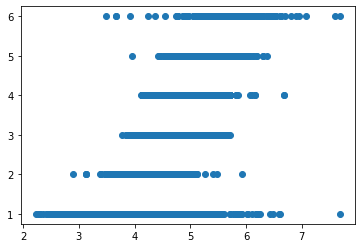

In [14]:
plt.scatter(np.log(all_data.area_total), all_data.rooms)
print(np.min(all_data.area_total[all_data.rooms == 2]))
all_data.rooms[all_data.area_total < 18.0] = 1

In [15]:
print(np.max(all_data.area_total[all_data.rooms == 1]))
print(all_data[all_data.area_total == 2181])

# ARE THERE MULTIPLE ENTRIES FOR A SINGLE FLAT???

2181.0
       seller         price  area_total  area_kitchen  area_living  floor  \
3217      NaN  2.600000e+09      2181.0           NaN          NaN   95.0   
21414     NaN  2.600000e+09      2181.0           NaN          NaN   95.0   

       rooms  ceiling  condition  phones  ...  longitude  district  \
3217     6.0      NaN        1.0     1.0  ...  37.537083       0.0   
21414    1.0      3.5        NaN     1.0  ...  37.537083       0.0   

       constructed  material  stories         street_and_address bathrooms  \
3217        2011.0       2.0     95.0  набережная Пресненская 12       NaN   
21414       2011.0       2.0     95.0  набережная Пресненская 12       NaN   

       balconies_and_loggias  dist_from_city_center  dist_to_nearest_metro  
3217                     NaN               3.937812                     53  
21414                    NaN               3.937812                     53  

[2 rows x 21 columns]


In [16]:
print("Amount of duplicates in all data: ", len(all_data[all_data.duplicated()]))
# Drop dups from imputation data
all_data_no_dups = all_data.drop(all_data[all_data.duplicated()].index, axis = 0)
# Drop dups from training data
print("Amount of duplicates in all data without duplicates: ", len(all_data_no_dups[all_data_no_dups.duplicated()]))

Amount of duplicates in all data:  768
Amount of duplicates in all data without duplicates:  0


In [17]:
keys = np.asarray(all_data.keys())
print(keys)
no_seller = np.delete(keys, 0)
no_area_total = np.delete(keys, 2)
no_area_kitchen = np.delete(keys, 3)
no_area_living = np.delete(keys, 4)
no_floor = np.delete(keys, 5)
no_rooms = np.delete(keys, 6)
no_ceiling = np.delete(keys, 7)
no_condition = np.delete(keys, 8)
no_phones = np.delete(keys, 9)
no_latitude = np.delete(keys, 10)
no_longitude = np.delete(keys, 11)
no_district = np.delete(keys, 12)
#no_street = np.delete(keys, 13)
no_constructed = np.delete(keys, 13)
no_material = np.delete(keys, 14)
no_stories = np.delete(keys, 15)
no_street_and_address = np.delete(keys, 16)
no_bathrooms = np.delete(keys, 17)
no_balconies_and_loggias = np.delete(keys, 18)
no_dist_from_city_center = np.delete(keys, 19)

print(no_dist_from_city_center)


['seller' 'price' 'area_total' 'area_kitchen' 'area_living' 'floor'
 'rooms' 'ceiling' 'condition' 'phones' 'latitude' 'longitude' 'district'
 'constructed' 'material' 'stories' 'street_and_address' 'bathrooms'
 'balconies_and_loggias' 'dist_from_city_center' 'dist_to_nearest_metro']
['seller' 'price' 'area_total' 'area_kitchen' 'area_living' 'floor'
 'rooms' 'ceiling' 'condition' 'phones' 'latitude' 'longitude' 'district'
 'constructed' 'material' 'stories' 'street_and_address' 'bathrooms'
 'balconies_and_loggias' 'dist_to_nearest_metro']


In [18]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 3000)

print("Amount of duplicates in big 3: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (np.isnan(all_data_no_dups.price))]))
print((all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (np.isnan(all_data_no_dups.price))].sort_values(["area_total", "street_and_address", "floor"])))


Amount of duplicates in big 3:  1689
      seller  price  area_total  area_kitchen  area_living  floor  rooms  ceiling  condition  phones   latitude  longitude  district  constructed  material  stories                     street_and_address  bathrooms  balconies_and_loggias  dist_from_city_center  dist_to_nearest_metro
4115     1.0    NaN       16.00           NaN          NaN    1.0    1.0      NaN        0.0     1.0  55.603863  37.586410       5.0       1971.0       3.0      9.0                Чертановская улица 54К2        1.0                    1.0              16.272017                     11
8981     1.0    NaN       16.00           NaN          NaN    1.0    1.0     2.64        1.0     1.0  55.603863  37.586410       5.0       1971.0       3.0      9.0                Чертановская улица 54К2        1.0                    1.0              16.272017                     11
1997     NaN    NaN       17.00           NaN          NaN    1.0    1.0      NaN        1.0     1.0  55.682645

In [19]:
sort = no_seller.tolist()
sort.append("seller")
print("Amount of duplicates in except for seller: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_seller, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_seller, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values(sort))
idx_to_drop = all_data_no_dups[(all_data_no_dups.duplicated(subset=no_seller, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values(sort).index[1::2]
print(len(idx_to_drop), idx_to_drop.values)
all_data_no_dups = all_data_no_dups.drop(idx_to_drop)
print("Amount of duplicates in except for seller: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_seller, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print(len(all_data_no_dups))
print("Amount of duplicates in big 3: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (~np.isnan(all_data_no_dups.price))]))


Amount of duplicates in except for seller:  116
       seller       price  area_total  area_kitchen  area_living  floor  rooms  ceiling  condition  phones   latitude  longitude  district  constructed  material  stories               street_and_address  bathrooms  balconies_and_loggias  dist_from_city_center  dist_to_nearest_metro
4207      1.0   3650000.0       20.00           3.0         14.0   14.0    1.0      NaN        0.0     1.0  55.968000  37.150583       9.0       2018.0       2.0     17.0       проспект Георгиевский 37к1        1.0                    NaN              37.070065                      0
13838     2.0   3650000.0       20.00           3.0         14.0   14.0    1.0      NaN        0.0     1.0  55.968000  37.150583       9.0       2018.0       2.0     17.0       проспект Георгиевский 37к1        1.0                    NaN              37.070065                      0
20316     1.0   3700000.0       35.00          10.9         18.2    1.0    1.0      NaN        2.0  

In [20]:
print("Amount of duplicates in except for area_total: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_area_total, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
sort = no_seller.tolist()
sort.append("area_total")
print(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_area_total, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values(sort))

Amount of duplicates in except for area_total:  65
       seller        price  area_total  area_kitchen  area_living  floor  rooms  ceiling  condition  phones   latitude  longitude  district  constructed  material  stories               street_and_address  bathrooms  balconies_and_loggias  dist_from_city_center  dist_to_nearest_metro
18601     1.0    5200000.0       28.00           6.0         16.0    9.0    1.0     2.64        1.0     2.0  55.626787  37.482115       6.0       1973.0       3.0      9.0           улица Теплый Стан 21К3        1.0                    NaN              15.566164                      9
15030     1.0    5200000.0       30.00           6.0         16.0    9.0    1.0     2.64        1.0     2.0  55.626787  37.482115       6.0       1973.0       3.0      9.0           улица Теплый Стан 21К3        1.0                    NaN              15.566164                      9
4227      1.0    5400000.0       34.00           7.8         15.8    2.0    1.0      NaN      

In [21]:
print("Amount of duplicates in except for area_kitchen: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_area_kitchen, keep = False)) & (~np.isnan(all_data_no_dups.price))]))

Amount of duplicates in except for area_kitchen:  10


In [22]:
print("Amount of duplicates in except for area_living: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_area_living, keep = False)) & (~np.isnan(all_data_no_dups.price))]))

Amount of duplicates in except for area_living:  24


In [23]:
print("Amount of duplicates in except for floor: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_floor, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
sort = no_seller.tolist()
sort.append("floor")
print(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_floor, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values(sort))
print("Amount of duplicates in big 3: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (~np.isnan(all_data_no_dups.price))]))

Amount of duplicates in except for floor:  285
       seller       price  area_total  area_kitchen  area_living  floor  rooms  ceiling  condition  phones   latitude  longitude  district  constructed  material  stories                    street_and_address  bathrooms  balconies_and_loggias  dist_from_city_center  dist_to_nearest_metro
6179      3.0   3539760.0       24.08           4.0         13.4    7.0    1.0     2.70        NaN     1.0  55.521170  37.354734      11.0       2022.0       2.0     16.0  Новые Ватутинки центральный мкр к2/3        1.0                    NaN              29.738979                      0
18704     3.0   3539760.0       24.08           4.0         13.4   11.0    1.0     2.70        NaN     1.0  55.521170  37.354734      11.0       2022.0       2.0     16.0  Новые Ватутинки центральный мкр к2/3        1.0                    NaN              29.738979                      0
10813     3.0   3746800.0       27.55           4.0         15.5    2.0    1.0     2.7

In [24]:
print("Amount of duplicates in except for rooms: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_rooms, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in big 3: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (~np.isnan(all_data_no_dups.price))]))


Amount of duplicates in except for rooms:  45
Amount of duplicates in big 3:  1879


In [25]:
print("Amount of duplicates in except for ceiling: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_ceiling, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_ceiling, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values(["area_total", "ceiling"]))
print(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_ceiling, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values(["price", "ceiling"]).ceiling.values)
print("Amount of duplicates in big 3: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (~np.isnan(all_data_no_dups.price))]))


Amount of duplicates in except for ceiling:  123
       seller        price  area_total  area_kitchen  area_living  floor  rooms  ceiling  condition  phones   latitude  longitude  district  constructed  material  stories                street_and_address  bathrooms  balconies_and_loggias  dist_from_city_center  dist_to_nearest_metro
22136     1.0    2800000.0       14.00           NaN          NaN    1.0    1.0     2.64        2.0     1.0  55.641808  37.534613       6.0       1970.0       NaN      9.0         Миклухо-Маклая улица 57К2        1.0                    1.0              12.709104                     14
4724      1.0    2800000.0       14.00           NaN          NaN    1.0    1.0      NaN        2.0     1.0  55.641808  37.534613       6.0       1970.0       NaN      9.0         Миклухо-Маклая улица 57К2        1.0                    1.0              12.709104                     14
20100     NaN    4000000.0       29.47           NaN          NaN    8.0    1.0     2.64     

In [26]:
print("Amount of duplicates in except for phones: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_phones, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
#print(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_phones, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values(["price", "phones"]))
# Drop the one with less phones by sorting for price and phones and dropping the first one of the pairs.
idx_to_drop = all_data_no_dups[(all_data_no_dups.duplicated(subset=no_phones, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values(["price", "phones"]).index[::2]
all_data_no_dups = all_data_no_dups.drop(idx_to_drop)
print("Amount of duplicates in except for phones: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_phones, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in big 3: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (~np.isnan(all_data_no_dups.price))]))


Amount of duplicates in except for phones:  42
Amount of duplicates in except for phones:  0
Amount of duplicates in big 3:  1840


In [27]:
print("Amount of duplicates in except for bathrooms: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_bathrooms, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
#print(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_bathrooms, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values("price"))
idx_to_drop = all_data_no_dups[(all_data_no_dups.duplicated(subset=no_bathrooms, keep = False)) & (~np.isnan(all_data_no_dups.price)) & (np.isnan(all_data_no_dups.bathrooms))].index
all_data_no_dups = all_data_no_dups.drop(index = idx_to_drop)
print("Amount of duplicates in except for bathrooms: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_bathrooms, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("The two duplicates are okay, they have different amounts of bathrooms that are not NaN.")

Amount of duplicates in except for bathrooms:  14
Amount of duplicates in except for bathrooms:  2
The two duplicates are okay, they have different amounts of bathrooms that are not NaN.


In [28]:
# THE SAME DATA EXCEPT FOR BALCONIES AND LOGGIAS
print("Amount of duplicates in except for balconies and loggias: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_balconies_and_loggias, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
# Find all columns where everything is duplicate except for the balconies and loggias and where there is a price. Sort values by balconies and loggias and drop the ones where the value is NaN.
#print(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_balconies_and_loggias, keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values("balconies_and_loggias"))
idx_to_drop = all_data_no_dups[(all_data_no_dups.duplicated(subset=no_balconies_and_loggias, keep = False)) & (~np.isnan(all_data_no_dups.price)) & (np.isnan(all_data_no_dups.balconies_and_loggias))].index
all_data_no_dups = all_data_no_dups.drop(index = idx_to_drop)
print("Amount of duplicates in except for balconies and loggias: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_balconies_and_loggias, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("The two duplicates are okay, they have different amounts of balconies and loggias that are not NaN.")

Amount of duplicates in except for balconies and loggias:  12
Amount of duplicates in except for balconies and loggias:  2
The two duplicates are okay, they have different amounts of balconies and loggias that are not NaN.


In [29]:
print("Amount of duplicates in except for condition: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_constructed, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in except for latitude: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_latitude, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in except for longitude: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_longitude, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in except for district: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_district, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
#print("Amount of duplicates in except for street: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_street, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in except for constructed: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_constructed, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in except for material: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_material, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in except for stories: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_stories, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in except for street_and_address: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_street_and_address, keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print("Amount of duplicates in except for dist_from_city_center: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=no_dist_from_city_center, keep = False)) & (~np.isnan(all_data_no_dups.price))]))

Amount of duplicates in except for condition:  0
Amount of duplicates in except for latitude:  0
Amount of duplicates in except for longitude:  0
Amount of duplicates in except for district:  0
Amount of duplicates in except for constructed:  0
Amount of duplicates in except for material:  0
Amount of duplicates in except for stories:  0
Amount of duplicates in except for street_and_address:  0
Amount of duplicates in except for dist_from_city_center:  0


Imputation

In [30]:
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 3000)

print("Amount of duplicates in big 3: ", len(all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (~np.isnan(all_data_no_dups.price))]))
print((all_data_no_dups[(all_data_no_dups.duplicated(subset=["price", "street_and_address", "floor", "area_total"], keep = False)) & (~np.isnan(all_data_no_dups.price))].sort_values("price")))


Amount of duplicates in big 3:  1821
       seller         price  area_total  area_kitchen  area_living  floor  rooms  ceiling  condition  phones   latitude  longitude  district  constructed  material  stories                                 street_and_address  bathrooms  balconies_and_loggias  dist_from_city_center  dist_to_nearest_metro
5986      NaN  2.790000e+06       12.50           NaN        10.50    2.0    1.0     3.00        1.0     1.0  55.749927  37.714204       4.0          NaN       0.0      5.0                               шоссе Энтузиастов 18        NaN                    NaN               7.147017                     37
10301     NaN  2.790000e+06       12.50           NaN          NaN    2.0    1.0      NaN        NaN     0.0  55.749927  37.714204       4.0          NaN       0.0      5.0                               шоссе Энтузиастов 18        NaN                    NaN               7.147017                     37
22136     1.0  2.800000e+06       14.00           N

In [31]:
import category_encoders as ce

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["seller", "condition", "material", "street_and_address"]
numerical_columns = ["area_total", "area_living", "area_kitchen", "bathrooms", "floor", "rooms", "ceiling", "phones", "balconies_and_loggias", "constructed", "stories"]
boolean_columns = []
# Encode string-addresses into integers
string_encoder = LabelEncoder()
all_data["street_and_address"] = string_encoder.fit_transform(all_data.street_and_address)

categorical_imputer = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
categorical_imputer.fit(all_data_no_dups[categorical_columns])
all_data[categorical_columns] = categorical_imputer.transform(all_data[categorical_columns])
#binary_encoder = ce.BinaryEncoder(cols = categorical_columns)
#cat_encoded_columns = binary_encoder.fit_transform(all_data[categorical_columns])

#boolean_imputer = SimpleImputer(missing_values = np.nan, strategy = "most_frequent")
#all_data[boolean_columns] = boolean_imputer.fit_transform(all_data[boolean_columns])

#all_data = all_data.drop(categorical_columns, axis = 1)
#all_data = pd.concat([all_data, cat_encoded_columns], axis = 1)

#numerical_imputer = IterativeImputer(missing_values = np.nan, random_state = 0)
#numerical_imputer.fit(all_data_no_dups[numerical_columns])
#all_data[numerical_columns] = numerical_imputer.transform(all_data[numerical_columns])

all_data.fillna(-999, inplace = True)

le = LabelEncoder()
#all_data.street = le.fit_transform(all_data.street)

#all_data.area_total = np.log1p(all_data.area_total)
#all_data.area_living = (all_data.area_living)
#all_data.area_kitchen = (all_data.area_kitchen)
#print(all_data[np.isnan(all_data.price)])
#print(np.sum(np.isnan(all_data)))


In [32]:
train_data = all_data[0:num_of_training_samples]
test_data = all_data[num_of_training_samples:len(all_data)]
#print(test_data.head(100))

print("Amount of duplicates in train data: ", len(train_data[train_data.duplicated()]))
train_data = train_data.drop(train_data[train_data.duplicated()].index, axis = 0)

price_per_district = train_data.groupby("district").mean().price
area_per_district = train_data.groupby("district").mean().area_total

train_data["price_per_sq_dist_cat"], bins = pd.qcut(train_data.dist_from_city_center, q = 150, retbins = True)
test_data["price_per_sq_dist_cat"] = pd.cut(test_data.dist_from_city_center, bins = bins)

price_per_dist = train_data.groupby("price_per_sq_dist_cat").mean().price
area_per_dist = train_data.groupby("price_per_sq_dist_cat").mean().area_total

a = np.log(price_per_district/area_per_district)
b = np.log(price_per_dist/area_per_dist)

train_data = pd.concat([train_data, pd.DataFrame(columns = ["sqm_per_dist"])], axis = 1)
test_data = pd.concat([test_data, pd.DataFrame(columns = ["sqm_per_dist"])], axis = 1)

train_data["district"] = train_data["district"].map(a).astype(float)
test_data["district"] = test_data["district"].map(a).astype(float)

train_data["sqm_per_dist"] = train_data["price_per_sq_dist_cat"].map(b).astype(float)
test_data["sqm_per_dist"] = test_data["price_per_sq_dist_cat"].map(b).astype(float)

train_data = train_data.drop("price_per_sq_dist_cat", axis = 1)
test_data = test_data.drop("price_per_sq_dist_cat", axis = 1)

Amount of duplicates in train data:  510


In [33]:
#print(np.sum(np.sum(np.isnan(all_data))))
train_data.area_total = np.log1p(train_data.area_total)
test_data.area_total = np.log1p(test_data.area_total)
#train_data.area_living = np.log1p(train_data.area_living)
#test_data.area_living = np.log1p(test_data.area_living)
#train_data.area_kitchen = np.log1p(train_data.area_kitchen)
#test_data.area_kitchen = np.log1p(test_data.area_kitchen)

In [34]:
print(len(test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center < b.index[0].right)]))
print(len(test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center > b.index[len(b)-1].left)]))


print(len(test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center < b.index[0].right)]))
print(len(test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center > b.index[len(b)-1].left)]))

test_data.district[(np.isnan(test_data.district)) & (test_data.district < a[0])] = a[0]
test_data.district[(np.isnan(test_data.district)) & (test_data.district > a[len(a)-1])] = a[len(a)-1]

test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center < b.index[0].right)] = b[0]
test_data.sqm_per_dist[(np.isnan(test_data.sqm_per_dist)) & (test_data.dist_from_city_center > b.index[len(b)-1].left)] = b[len(b)-1]



83
0
83
0


In [35]:
# splitting

print(train_data.head())

#train_data = train_data.sort_values(by = "price")
#x_val = train_data.iloc[::10, :]
#train_data = train_data.drop(x_val.index)
#x_train = train_data.sort_index()

y_train = train_data.price
#print(y_train)
#y_val = x_val.price

x_train = train_data.drop("price", axis = 1)
test_data = test_data.drop("price", axis = 1)
#x_val = x_val.drop("price", axis = 1)

#x_train = x_train.drop("street", axis = 1)
#test_data = test_data.drop("street", axis = 1)
#x_val = x_val.drop("street", axis = 1)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
test_data = np.asarray(test_data)

print(x_train.shape)

   seller       price  area_total  area_kitchen  area_living  floor  rooms  ceiling  condition  phones   latitude  longitude   district  constructed  material  stories  street_and_address  bathrooms  balconies_and_loggias  dist_from_city_center  dist_to_nearest_metro  sqm_per_dist
0     3.0   7139520.0    4.097672          12.5         31.0    2.0    2.0     2.65        1.0     1.0  55.544046  37.478055  11.839914       2021.0       3.0      9.0              1271.0        2.0                 -999.0              24.145472                      6     11.813623
1     3.0  10500000.0    4.488636          14.2         48.0   18.0    3.0  -999.00        3.0     1.0  55.861282  37.666647  12.225619       2010.0       3.0     25.0              9050.0        2.0                    1.0              13.056109                     13     12.106797
2     3.0   9019650.0    4.375757          22.5         40.8   12.0    3.0     2.65        1.0     1.0  55.663299  37.515335  12.378677       2021.0      

In [36]:
from tensorflow.keras.losses import mean_squared_logarithmic_error
from tensorflow.keras.backend import sqrt

def root_mean_squared_log_error(y_true, y_pred):
    return sqrt(mean_squared_logarithmic_error(y_true, y_pred))

In [37]:

from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(
    n_estimators=100,
    criterion='mse',
    max_depth=None,
#    min_samples_split=2,
#    min_samples_leaf=2,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None
)

In [38]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, ElasticNet, RidgeCV, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from lightgbm import LGBMRegressor


model5 = LGBMRegressor(
    objective="regression",
    num_leaves=32,
    max_depth=5, 
    random_state=42, 
    metric='mse',
    n_jobs=-2, 
    n_estimators=5000,
    colsample_bytree=0.7,
    subsample=0.7,
    verbose = -1
)

model_xgb_1 = XGBRegressor(
    n_estimators=1500,
    max_depth=5,
    n_jobs=-2,
    booster='gbtree',
    enable_categorical = True,
    colsample_bytree=0.7,
    subsample=0.7,
    learning_rate = 0.1,
    random_state=42069
)

model_cat_1 = CatBoostRegressor(
    iterations=2000,
    depth = 7,
    learning_rate=0.1,
    l2_leaf_reg=0.45,
    silent=True,
    random_seed = 42069
)

final_model = RidgeCV()


base_learners = [
    ('xgb_tree', model_xgb_1),
    #("random_forest", model2),
    ("lgbm", model5),
    # ('knn_256', model3),
    #('knn_512', model_knn_512),
    # ('knn_1024', model5),
    ('catboost', model_cat_1),
]

stacking_model = StackingRegressor(estimators=base_learners, n_jobs=-2, final_estimator=final_model, cv = 5, verbose = 1)


In [39]:
from sklearn.model_selection import KFold
i = 0
models = []
errors = []
predictions_test = []
kf = KFold(random_state = 42069, shuffle = True)
for train_index, test_index in kf.split(x_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train_fold, x_test_fold = x_train[train_index], x_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    current_model = stacking_model.fit(x_train_fold, np.log(y_train_fold))
    models.append(current_model)
    predictions_val = np.exp(stacking_model.predict(x_test_fold))
    errors.append(root_mean_squared_log_error(y_test_fold, predictions_val))

    predictions_test.append(np.exp(stacking_model.predict(test_data)))

    print("Error: ", root_mean_squared_log_error(y_test_fold, predictions_val))
print("Mean error: ", np.mean(errors))
0.12369840466589961
0.12336180205842127
0.12260222104690519

TRAIN: [    0     1     2 ... 22772 22773 22774] TEST: [   10    14    15 ... 22764 22769 22770]
Error:  tf.Tensor(0.1218908267105606, shape=(), dtype=float64)
TRAIN: [    0     1     3 ... 22771 22773 22774] TEST: [    2     5     6 ... 22752 22767 22772]
Error:  tf.Tensor(0.12122601563163166, shape=(), dtype=float64)
TRAIN: [    1     2     4 ... 22770 22771 22772] TEST: [    0     3    16 ... 22766 22773 22774]
Error:  tf.Tensor(0.12288074388728694, shape=(), dtype=float64)
TRAIN: [    0     1     2 ... 22772 22773 22774] TEST: [    9    11    28 ... 22760 22768 22771]
Error:  tf.Tensor(0.13132175203331206, shape=(), dtype=float64)
TRAIN: [    0     2     3 ... 22772 22773 22774] TEST: [    1     4     7 ... 22745 22757 22763]
Error:  tf.Tensor(0.11754884797248438, shape=(), dtype=float64)
Mean error:  0.12297363724705512


0.12260222104690519

In [40]:
#0.12235860579812154
# 0.12202326703500511
# 0.12234221519377998
# 0.130322947873969
# 0.11596406933365036

# 5km
# 0.1218908267105606, 0.12122601563163166

#0.12227003991867298

# print(forest_importances)

#fig, ax = plt.subplots()
#forest_importances.plot.bar(ax=ax)
#ax.set_title("MDI or Gini Importance")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

In [41]:
print(predictions_test)
prediction = np.mean(predictions_test, axis = 0)
print(prediction)
submission = pd.DataFrame()
submission['id'] = test_ids
submission["price_prediction"] = prediction
submission.to_csv('simple_nn_submission.csv', index=False)

[array([30100964.5585079 ,  9299808.25180861,  6183285.82176589, ...,
        9564215.00347241,  9470641.29453873,  6118126.45317173]), array([31008178.05931112,  9602708.56762006,  6196128.37217469, ...,
        9697073.01529679,  9792083.50368488,  5935828.92918098]), array([31497212.02341629,  9503246.88518952,  6205689.58530221, ...,
        9164684.69903585, 10009487.13786568,  6749335.82164923]), array([31410627.46421756,  9297378.38472123,  6180489.84156825, ...,
        9168052.53048579,  9934750.27394835,  6405823.02005518]), array([32739957.23017579,  9723985.40725389,  6188402.31604073, ...,
        9478350.85706558,  9312227.12294799,  6427531.0582105 ])]
[31351387.86712574  9485425.49931866  6190799.18737035 ...
  9414475.22107128  9703837.86659713  6327329.05645352]
